In [ ]:
#Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier

##### yfinance is a popular open source library developed by Ran Aroussi as a means to access the financial data available on Yahoo Finance.






# Downloading the Dataset

*   Convert to csv
*  Convert Date to Datetime

*   Other Basic Cleaning




In [ ]:
# Create a Ticker object for the S&P 500 index (^GSPC) using the Yahoo Finance API
sp500 = yf.Ticker("^GSPC")

# Retrieve historical market data for the S&P 500 index from Yahoo Finance, covering the maximum available period
# The period parameter specifies the timeframe for which historical data is requested. Here, "max" indicates
# that data for the maximum available period will be retrieved.
sp500 = sp500.history(period="max")
sp500.index = sp500.index.date

# Download it as a CSV file
sp500csv = sp500.to_csv("stock_market_data.csv")

# Load the stock market data from a CSV file into a pandas DataFrame
sp500_downloaded = pd.read_csv("stock_market_data.csv", index_col=0)

# Convert the index of the DataFrame to datetime format
sp500_downloaded.index = pd.to_datetime(sp500_downloaded.index)

# Explanation:
# 1. pd.read_csv("stock_market_data.csv", index_col=0): This line reads the data from a CSV file named "stock_market_data.csv"
#    into a pandas DataFrame. It sets the first column of the CSV file as the index of the DataFrame.

# 2. pd.to_datetime(sp500.index): This line converts the index of the DataFrame to datetime format. This is useful if the index
#    represents dates or timestamps in a string format and we want to perform datetime operations on them. By converting them
#    to datetime format, we enable functionalities like date-based slicing, resampling, and plotting in pandas.

# Setting up the target



*   Decrease the size of the DataFrame
*   Delete irrelevant fields
*   Create new fields to determine the target



In [ ]:
#Looking at too much data would make the model more inaccurate.
#The market changes over time and the market shift would make old data worsen the model
#To prevent this, data from after 1990 is taken

specificDate = pd.to_datetime("1990-01-01").date()
sp500 = sp500.loc[specificDate:].copy()

#Deleting these columns from the data frame as they are for individual stocks and not required to index
del sp500["Dividends"]
del sp500["Stock Splits"]

# creating a column that shows the next day's closing price
sp500["Tomorrow"] = sp500["Close"].shift(-1)
# creating the target column that uses the "Tomorrow" column to see if the price increases the next day
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [ ]:
# Resulting matrix will look like this
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2024-02-26,5093.000000,5097.660156,5068.910156,5069.529785,3683930000,5078.180176,1
2024-02-27,5074.600098,5080.689941,5057.290039,5078.180176,3925950000,5069.759766,0
2024-02-28,5067.200195,5077.370117,5058.350098,5069.759766,3789370000,5096.270020,1
2024-02-29,5085.359863,5104.990234,5061.890137,5096.270020,5219740000,5137.080078,1


# Setting up the initial ML model

Using a random forest classifier to predict whether the stock price would increase.

Using random forest because they are more resistant to overfitting than most models, run quick and pick up non-linear tendencies in the data.

Picking up non-linearity is important for our data. A higher closing price than from a year ago doesn't mean the target will also be higher, the target could be 0, implying non-linearity.

In [ ]:
# Creating a random forest with 500 decision trees ('n_estimators')
model = RandomForestClassifier(n_estimators=500, min_samples_split=100, random_state=1)

# Creating a test set of the last 100 items
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, n_estimators=500, random_state=1)

In [ ]:
# Generating predictions on the test set and converting into a pandas series
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [ ]:
# Calculating precision score by comparing our predictions with the target of the test set
precision_score(test["Target"], preds)

0.4642857142857143

[link text](https://)Our score is quite low as our initial model has not been fitted to the data well enough. Our model only predicted the right value just over 50% of the time.

<Axes: >

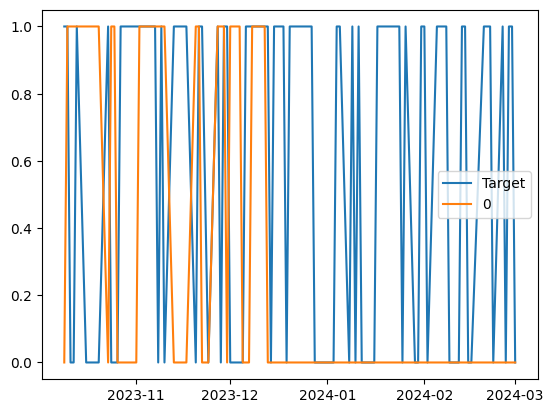

In [ ]:
combined = pd.concat([test["Target"], preds], axis=1)
# The orange line signifies our model's predictions and the blue line is the actual data.
combined.plot()

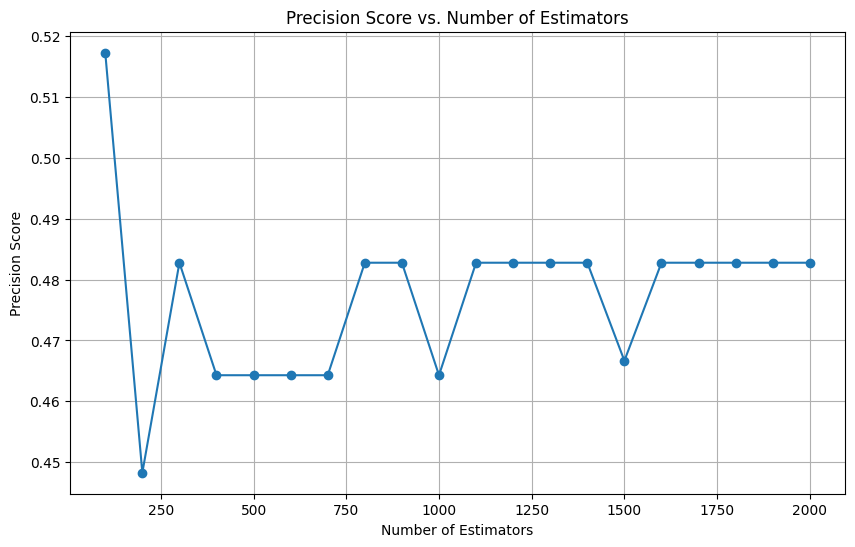

In [ ]:

# Define the range of n_estimators values
estimator_range = range(100, 2100, 100)

# Initialize lists to store precision scores
precision_scores = []

# Loop through different values of n_estimators
for n_estimators in estimator_range:
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=100, random_state=1)
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict(test[predictors])

    # Calculate precision score and append to the list
    precision = precision_score(test["Target"], preds)
    precision_scores.append(precision)

# Plot precision scores against n_estimators
plt.figure(figsize=(10, 6))
plt.plot(estimator_range, precision_scores, marker='o')
plt.title('Precision Score vs. Number of Estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Precision Score')
plt.grid(True)
plt.show()


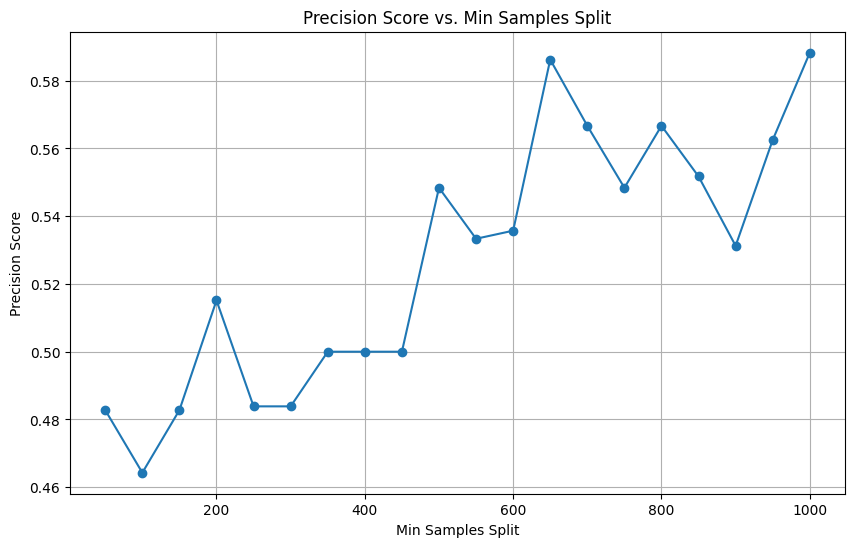

In [ ]:

# Define the range of min_samples_split values
min_samples_split_range = range(50, 1001, 50)

# Initialize lists to store precision scores
precision_scores = []

# Loop through different values of min_samples_split
for min_samples_split in min_samples_split_range:
    # Create and fit the model
    model = RandomForestClassifier(n_estimators=500, min_samples_split=min_samples_split, random_state=1)
    model.fit(train[predictors], train["Target"])

    # Make predictions
    preds = model.predict(test[predictors])

    # Calculate precision score and append to the list
    precision = precision_score(test["Target"], preds)
    precision_scores.append(precision)

# Plot precision scores against min_samples_split
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_range, precision_scores, marker='o')
plt.title('Precision Score vs. Min Samples Split')
plt.xlabel('Min Samples Split')
plt.ylabel('Precision Score')
plt.grid(True)
plt.show()

BACKTESTING


In [ ]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def predict(train, test, predictors, model):
    # Fit the model on the training data
    model.fit(train[predictors], train["Target"])

    # Make predictions on the test data
    preds = model.predict(test[predictors])

    # Create a Series of predictions with index from the test data
    preds = pd.Series(preds, index=test.index, name="Predictions")

    # Combine the actual target values and the predictions into a DataFrame
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [ ]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    # Iterate through the data with a given start index and step size
    for i in range(start, data.shape[0], step):
        # Create train and test sets based on the current index and step size
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Generate predictions for the current test set using the predict function
        predictions = predict(train, test, predictors, model)

        # Append the predictions to the list
        all_predictions.append(predictions)

    # Concatenate all the predictions into a single DataFrame and return it
    return pd.concat(all_predictions)

In [ ]:
predictions = backtest(sp500, model, predictors)

In [ ]:
predictions["Predictions"].value_counts()

1    3334
0    2773
Name: Predictions, dtype: int64

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5320935812837433

In [ ]:
df = sp500.rename_axis('Date')

print(df)

                   Open         High          Low        Close      Volume  \
Date                                                                         
1990-01-02   353.399994   359.690002   351.980011   359.690002   162070000   
1990-01-03   359.690002   360.589996   357.890015   358.760010   192330000   
1990-01-04   358.760010   358.760010   352.890015   355.670013   177000000   
1990-01-05   355.670013   355.670013   351.350006   352.200012   158530000   
1990-01-08   352.200012   354.239990   350.540009   353.790009   140110000   
...                 ...          ...          ...          ...         ...   
2024-02-26  5093.000000  5097.660156  5068.910156  5069.529785  3683930000   
2024-02-27  5074.600098  5080.689941  5057.290039  5078.180176  3925950000   
2024-02-28  5067.200195  5077.370117  5058.350098  5069.759766  3789370000   
2024-02-29  5085.359863  5104.990234  5061.890137  5096.270020  5219740000   
2024-03-01  5098.509766  5140.330078  5094.160156  5137.080078  

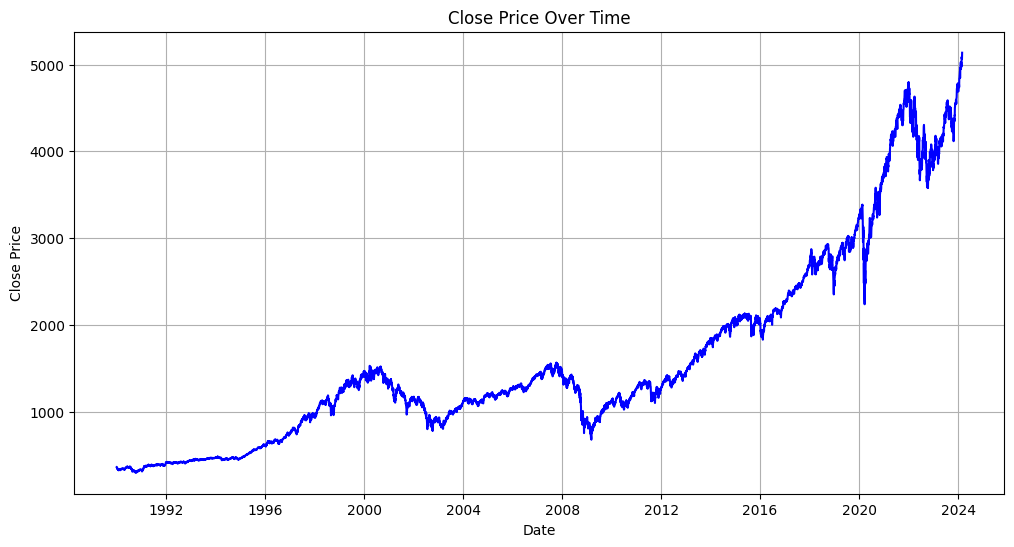

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], color='blue')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.show()

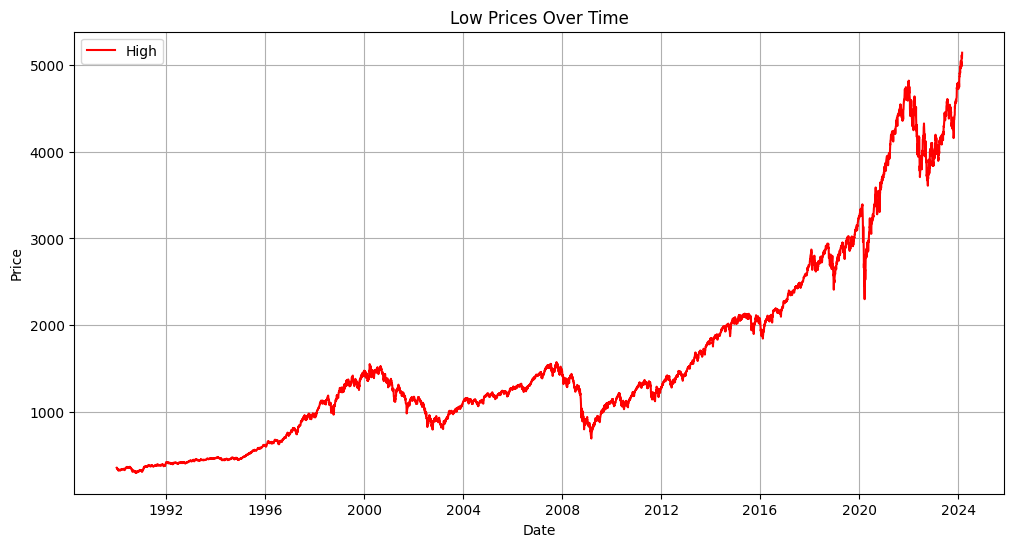

In [ ]:
# Plotting High Prices
plt.figure(figsize=(12, 6))
plt.plot(df['High'], label='High', color='red')
plt.title('Low Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

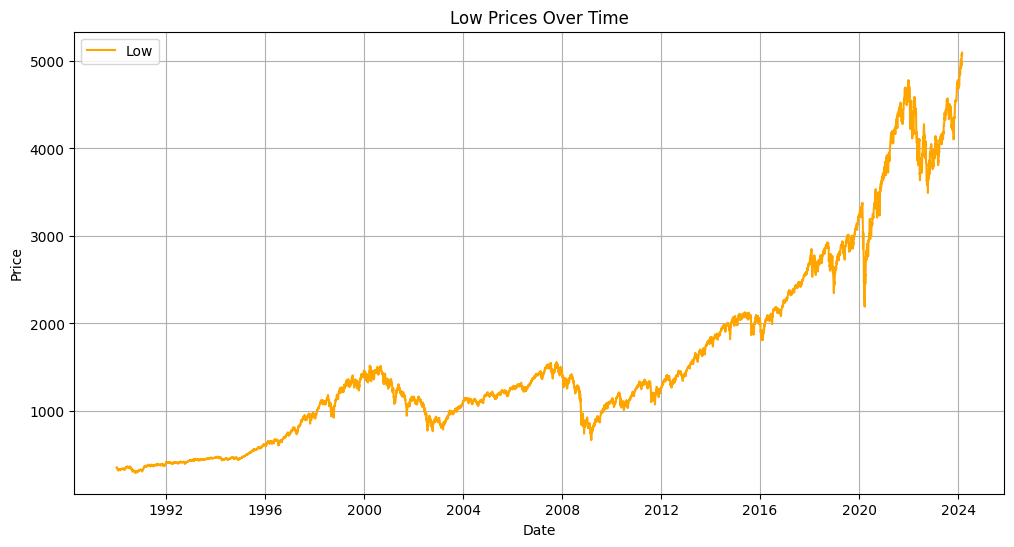

In [ ]:
# Plotting Low Prices
plt.figure(figsize=(12, 6))
plt.plot(df['Low'], label='Low', color='orange')
plt.title('Low Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


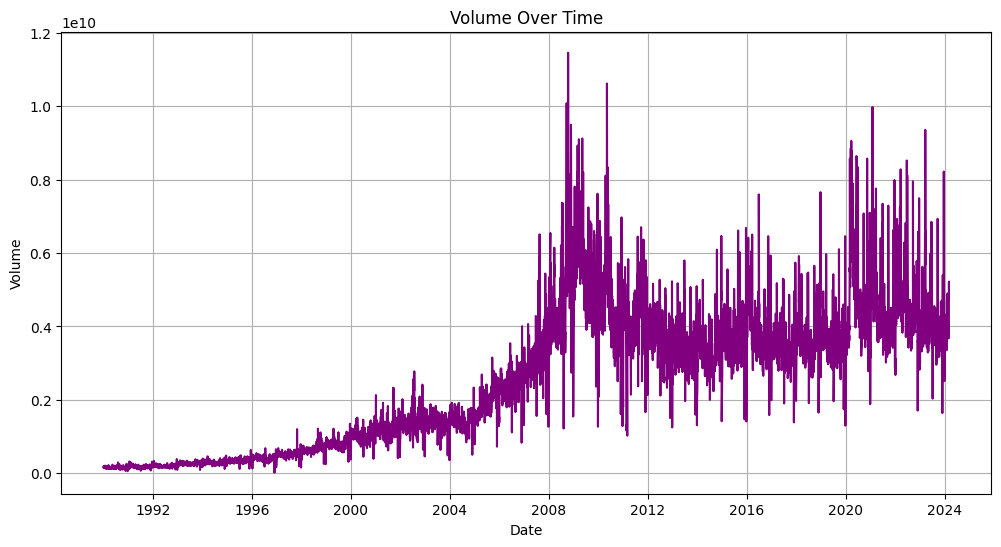

In [ ]:
# Plotting Volume
plt.figure(figsize=(12, 6))
plt.plot(df['Volume'], color='purple')
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

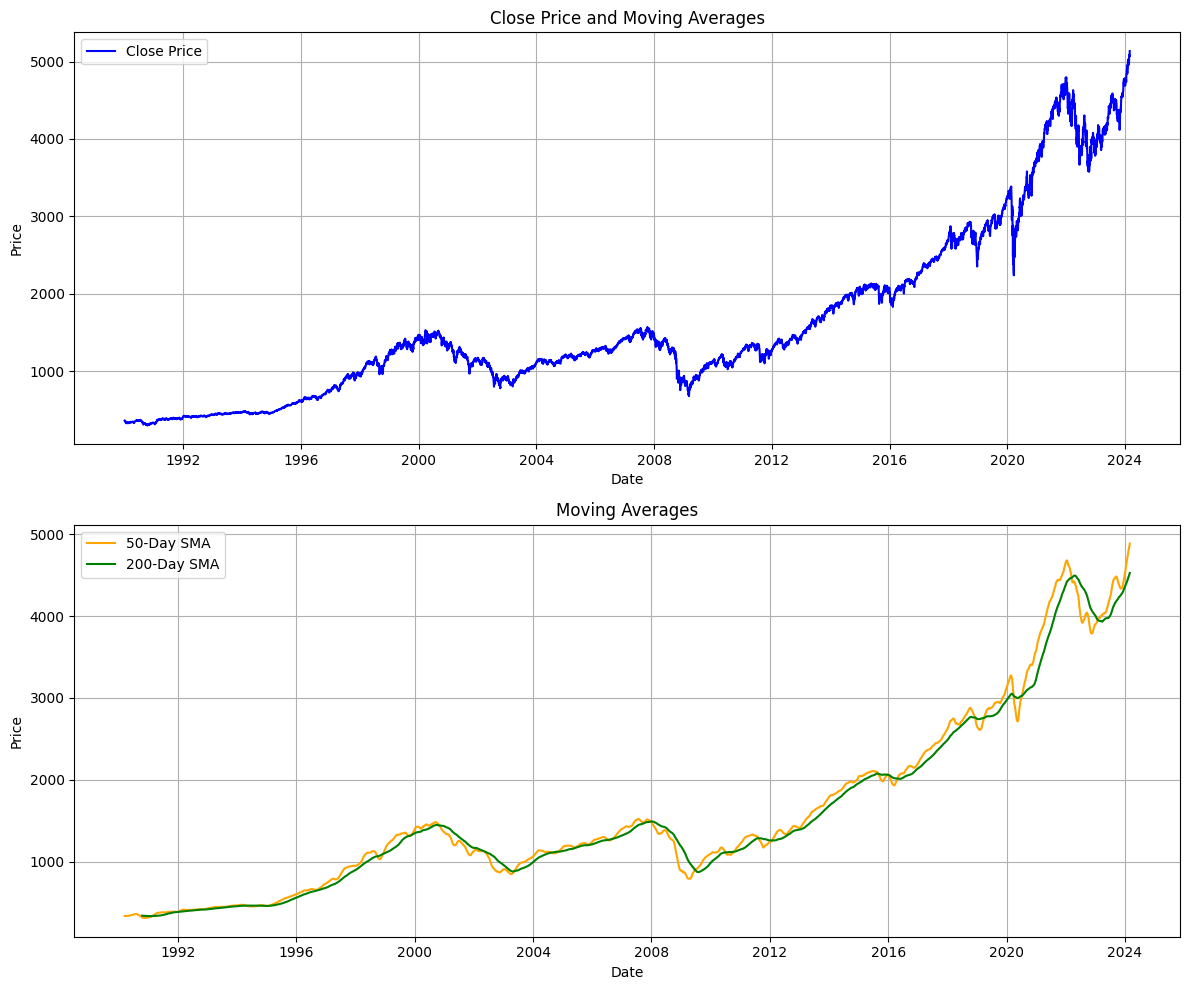

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate Moving Averages
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

# Plotting Moving Averages on subplots
plt.figure(figsize=(12, 10))

# Close Price Plot
plt.subplot(2, 1, 1)
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title('Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Moving Averages Plot
plt.subplot(2, 1, 2)
plt.plot(df['SMA_50'], label='50-Day SMA', color='orange')
plt.plot(df['SMA_200'], label='200-Day SMA', color='green')
plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# creating a column that shows the next day's closing price
df["Tomorrow_SMA50"] = df["SMA_50"].shift(-1)
# creating the target column that uses the "Tomorrow" column to see if the price increases the next day
df["Target_SMA50"] = (df["Tomorrow_SMA50"] > df["SMA_50"]).astype(int)

In [ ]:
# creating a column that shows the next day's closing price
df["Tomorrow_SMA200"] = df["SMA_200"].shift(-1)
# creating the target column that uses the "Tomorrow" column to see if the price increases the next day
df["Target_SMA200"] = (df["Tomorrow_SMA200"] > df["SMA_200"]).astype(int)

In [ ]:
# Creating a random forest with 500 decision trees ('n_estimators')
model = RandomForestClassifier(n_estimators=500, min_samples_split=100, random_state=1)

# Creating a test set of the last 100 items
train = df.iloc[:-100]
test = df.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low", "SMA_50"]
# Drop samples with missing values
train = train.dropna()
test = test.dropna()

# Fit the model to the training data
model.fit(train[predictors], train["Target_SMA50"])

# Predict using the model
predictions = model.predict(test[predictors])

In [ ]:
# Generating predictions on the test set and converting into a pandas series
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [ ]:
# Calculating precision score by comparing our predictions with the target of the test set
precision_score(test["Target_SMA50"], preds)

0.7525773195876289

In [ ]:
df

,Open,High,Low,Close,Volume,Tomorrow,Target,SMA_50,SMA_200,Tomorrow_SMA50,Target_SMA50,Tomorrow_SMA200,Target_SMA200
Date,,,,,,,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0,NaN,NaN,NaN,0,NaN,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0,NaN,NaN,NaN,0,NaN,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0,NaN,NaN,NaN,0,NaN,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1,NaN,NaN,NaN,0,NaN,0
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0,NaN,NaN,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-26,5093.000000,5097.660156,5068.910156,5069.529785,3683930000,5078.180176,1,4857.066807,4508.384297,4864.488613,1,4513.086997,1
2024-02-27,5074.600098,5080.689941,5057.290039,5078.180176,3925950000,5069.759766,0,4864.488613,4513.086997,4871.492812,1,4517.782695,1
2024-02-28,5067.200195,5077.370117,5058.350098,5069.759766,3789370000,5096.270020,1,4871.492812,4517.782695,4879.034414,1,4522.643645,1


In [ ]:
# Creating a random forest with 500 decision trees ('n_estimators')

# 2008 Crash check it
model = RandomForestClassifier(n_estimators=500, min_samples_split=100, random_state=1)

# Creating a test set of the last 100 items
train = df.iloc[:-100]
test = df.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low", "SMA_50", "SMA_200"]
# Drop samples with missing values
train = train.dropna()
test = test.dropna()

# Fit the model to the training data
model.fit(train[predictors], train["Target_SMA200"])

# Predict using the model
predictions = model.predict(test[predictors])


In [ ]:
# Generating predictions on the test set and converting into a pandas series
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)

In [ ]:
# Calculating precision score by comparing our predictions with the target of the test set
precision_score(test["Target_SMA200"], preds)

1.0